In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os
import subprocess as sp
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

def set_default_params(FigureWidth=3.375, factor=1.0):
  # Set global parameters
  params = {
            'lines.linewidth': 1+factor,
            'axes.labelsize': int(9*factor),
            'legend.fontsize': int(6.5*factor),
            'xtick.labelsize': int(9*factor),
            'ytick.labelsize': int(9*factor),
            'axes.titlesize': int(9*factor),
            'text.usetex': True,
            'font.family': 'serif'}
  plt.rcParams.update(params)
  plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def find_r0(interface_r, interface_z, initial_zcutoff=1e-2, zcutoff_increment=1e-2):
    r0 = 0
    found = False
    zcutoff = initial_zcutoff

    while not found:
        for r, z in zip(interface_r, interface_z):
            if z < zcutoff and r > r0:
                r0 = r
                found = True
        if not found:
            zcutoff += zcutoff_increment

    return r0, zcutoff

def gettingInterface(filename):
    exe = ["./getInterfaceAndAngle", filename]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    
    interface_r = []
    interface_z = []
    ang = []
    
    for line in temp2:
        if line.strip():  # Check if the line is not empty
            parts = line.split()
            if len(parts) == 4:
                x0, y0, tx, ty = map(float, parts)
                interface_r.append(y0)
                interface_z.append(x0)
                angle = math.atan2(tx, ty)  # Calculate the angle from the tangent vector
                angle *= -1/np.pi 
                ang.append(angle)
    
    r0, z0 = find_r0(interface_r, interface_z)

    # Sort interface points based on their distance from (r0, z0)
    distances = [(math.sqrt((r - r0)**2 + (z - z0)**2), r, z, angle) for r, z, angle in zip(interface_r, interface_z, ang)]
    distances.sort()  # Sort by the first element of the tuple, which is the distance

    sorted_interface_r = [r for _, r, _, _ in distances]
    sorted_interface_z = [z for _, _, z, _ in distances]
    sorted_ang = [angle for _, _, _, angle in distances]

    dr = np.gradient(sorted_interface_r)
    dz = np.gradient(sorted_interface_z)
    ds = np.sqrt(dr**2 + dz**2)
    s = np.cumsum(ds)
    
    return np.array(sorted_interface_r), np.array(sorted_interface_z), np.array(sorted_ang), np.array(s), r0, z0

def plot_interface(folder='Interface', t=50.0, show=False):
    
    place = 'TestCases/retract_v1/intermediate/snapshot-%5.4f' % t
    ImageName = '%s/interface-%8.8d.png' % (folder, t*1e4)
    
    # check if the data is in the right place
    if not os.path.exists(place):
        raise FileNotFoundError(f'Data is not in the right place: {place}')
    
    interface_r, interface_z, ang, s, r0, z0 = gettingInterface(place)
    
    FigureWidth = 7
    factor = FigureWidth / 3.375
    set_default_params(factor=factor)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FigureWidth * 2, FigureWidth))
    
    ax1.plot(interface_r, interface_z, '-', color='green')
    ax1.plot(r0, z0, 'ro', markersize=10)
    ax1.axhline(y=0.3, color='k', linestyle='--', linewidth=2)
    ax1.set_aspect('equal')
    ax1.set_xlim([0.0, 9.0])
    ax1.set_ylim([0.0, 9.0])
    ax1.set_xlabel(r'$r/h_0$')
    ax1.set_ylabel(r'$z/h_0$')
    
    # Create an inset axis
    axins = inset_axes(ax1, width="30%", height="30%", loc='upper right')
    axins.plot(interface_r, interface_z, '-', color='green')
    axins.plot(r0, z0, 'ro', markersize=10)
    axins.axhline(y=0.3, color='k', linestyle='--', linewidth=2)
    axins.set_xlim([r0 - 1, r0])
    axins.set_ylim([z0, z0 + 1])
    axins.set_aspect('equal')
    axins.axis('off')
    
    # Add a rectangle to highlight the zoomed area on the inset plot
    rect = patches.Rectangle((r0 - 1, z0), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
    axins.add_patch(rect)
    
    # Optionally, add a rectangle to highlight the zoomed area on the main plot
    ax1.indicate_inset_zoom(axins, edgecolor="black")
    
    title_str = r'$t/\sqrt{\rho_dh_0^3/\gamma} = %3.2f$' % t
    ax1.set_title(title_str)
    
    # find the last point where the interface z is below 0.3
    ind = np.where((interface_z < 0.3) & (s < 0.5 * s[-1]))[0][-1]
    ang0 = ang[ind]
    rInt = interface_r[ind]
    
    ax2.plot(s / s[-1], ang, '-')
    ax2.plot((s[ind] / s[-1], s[ind] / s[-1]), (-1, 1), '--', color='k', linewidth=1)
    
    ax2.set_xlabel(r'$s/s_{\text{max}}$')
    ax2.set_ylabel(r'$\theta/\pi$')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([-0.25, 0.51])
    title_str = r'Angle vs. distance away from the contact line'
    ax2.set_title(title_str)
    
    plt.savefig(ImageName, bbox_inches='tight')
    
    if show:
        plt.show()
    else:
        plt.close()
        
    return ang0, rInt

In [3]:
# Ensure the folder exists
folder = 'Interface'
os.makedirs(folder, exist_ok=True)

# Define the time range
time_range = np.arange(0.0, 59.55, 0.05)

# Preallocate arrays for time and angles
times = time_range
angles = np.zeros_like(time_range)
rInt = np.zeros_like(time_range)

# Loop through the time range and collect angles
show = False
for i, t in enumerate(time_range):
    ang, rInt_val = plot_interface(folder=folder, t=t, show=show)
    angles[i] = ang * 180  # Convert angle to degrees
    rInt[i] = rInt_val
    print(f'Contact angle at t = {t} is {ang * 180} degrees')

# Create a DataFrame from the collected data
data = {'Time': times, 'thInt': angles, 'rInt': rInt}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file = os.path.join(folder, 'angles.csv')
df.to_csv(csv_file, index=False)

print(f'Data saved to {csv_file}')

Contact angle at t = 0.0 is 73.13162819003726 degrees
Contact angle at t = 0.05 is 83.62715327357415 degrees
Contact angle at t = 0.1 is 67.65194287802441 degrees
Contact angle at t = 0.15000000000000002 is 55.27173306295046 degrees
Contact angle at t = 0.2 is 49.13039534654982 degrees
Contact angle at t = 0.25 is 45.2030578648026 degrees
Contact angle at t = 0.30000000000000004 is 41.83353921355874 degrees
Contact angle at t = 0.35000000000000003 is 38.7439293263639 degrees
Contact angle at t = 0.4 is 36.26549644153552 degrees
Contact angle at t = 0.45 is 33.84616490996746 degrees
Contact angle at t = 0.5 is 32.15403452551378 degrees
Contact angle at t = 0.55 is 31.127283465283234 degrees
Contact angle at t = 0.6000000000000001 is 29.45829669562898 degrees
Contact angle at t = 0.65 is 28.438818478369562 degrees
Contact angle at t = 0.7000000000000001 is 27.761804212716903 degrees
Contact angle at t = 0.75 is 26.959911669613838 degrees
Contact angle at t = 0.8 is 26.674796481124517 deg

(0.0, 9.0)

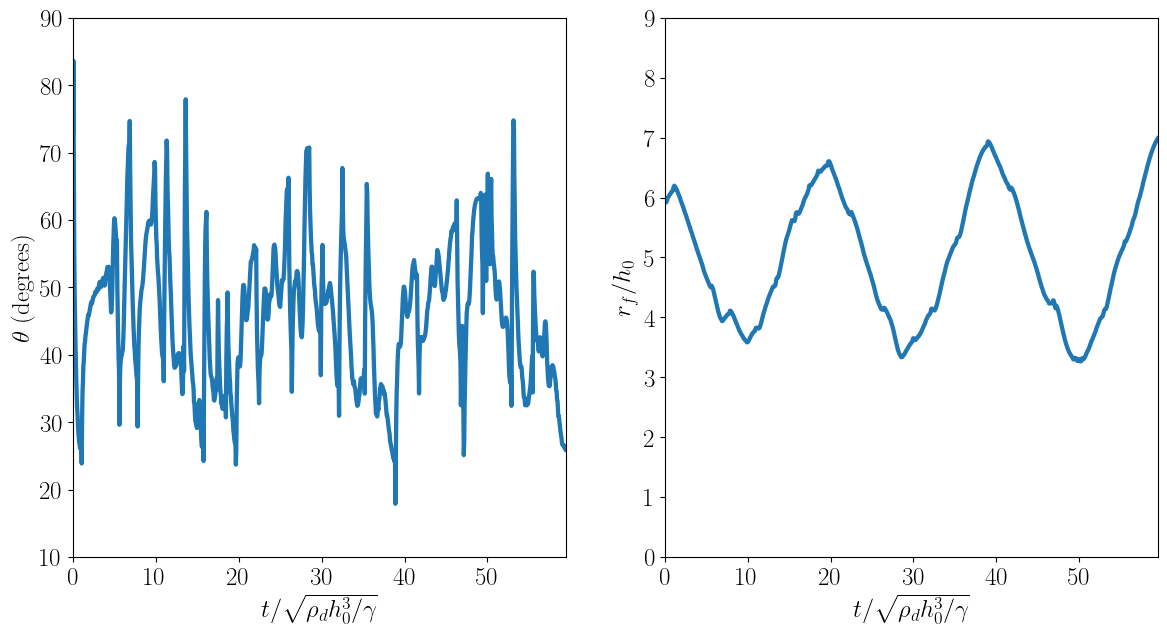

In [5]:
df = pd.read_csv('angles.csv')
t = df['Time']
th = df['thInt']
r = df['rInt']

FigureWidth = 7
factor = FigureWidth / 3.375
set_default_params(factor=factor)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FigureWidth * 2, FigureWidth))

ax1.plot(t, th, '-')
ax1.set_xlabel(r'$t/\sqrt{\rho_dh_0^3/\gamma}$')
ax1.set_ylabel(r'$\theta$ (degrees)')
ax1.set_xlim([0, t.max()])
ax1.set_ylim([10, 90])

ax2.plot(t, r, '-')
ax2.set_xlabel(r'$t/\sqrt{\rho_dh_0^3/\gamma}$')
ax2.set_ylabel(r'$r_f/h_0$')
ax2.set_xlim([0, t.max()])
ax2.set_ylim([0, 9])